In [1]:
# Dependencies
import sys
sys.path.append('./helpers/')

from model_simulation import *

import numpy as np
import tensorflow as tf
import pickle5 as pkl
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Testing data must have the following format
# stimulus: (nx, ny, nt_test, 1)
# spikes: (n_cells, nt_test, n_rep_test)

# Load testing dataset
with open('data/' + 'data_bars_OFF_repeated' + '.pkl', 'rb') as f:
    data_test = pkl.load(f)
    
spikes_test = data_test['spikes']
stimulus_test = data_test['stimulus']
spikes_test = spikes_test[:,:2000,:]
stimulus_test = stimulus_test[:,:,:2000]

print(f'Testing data:\n',
    f'stimulus shape: {stimulus_test.shape}\n',
      f'spikes shape: {spikes_test.shape}')

Testing data:
 stimulus shape: (31, 1, 2000)
 spikes shape: (6, 2000, 54)


In [3]:
# Reshape the stimulus
n_cells, nt_test, n_rep_test = spikes_test.shape
nx, ny, dull = stimulus_test.shape
stimulus_test = np.reshape(stimulus_test, [nx*ny, nt_test], order='F')

In [4]:
### GLM
path_filters = './model_filters/GLM/'
with open(path_filters+'filters.pkl', 'rb') as f:
    (stim_filters, bias_list, coupl_filters, self_filters, tau_r_list) = pkl.load(f)

In [5]:
n_rep_sim = 50

# Some parameters
nt_integ_stim = stim_filters[0].shape[1]
nt_integ_int = np.max([coupl_filters[0].shape[1],self_filters[0].shape[1]])
nt_sim = nt_test - nt_integ_stim

# Stimulus effect
stim = stimulus_test[np.newaxis,:,:, np.newaxis]-0.5
h_stim = np.zeros((n_cells, nt_sim))
for cell in range(n_cells):
    h_temp = tf.nn.conv2d(stim, stim_filters[cell], strides=1, padding='VALID')
    h_stim[cell,:] = h_temp.numpy().squeeze()[:-1]+bias_list[cell]

# Simulation
spikes_sim =  np.zeros((n_cells, nt_sim+nt_integ_int, n_rep_sim))
for rep in range(n_rep_sim):
    if (rep+1)%10==0: print(f'{rep+1} repetitions done')
    for t in range(nt_sim):
        spikes_past = spikes_sim[:,t:t+nt_integ_int, rep]
        h_int = int_potential(spikes_past, coupl_filters, self_filters, tau_r_list)
        lbdt = np.exp(h_int + h_stim[:,t])
        
        # hard refractory period period
        for cell in range(n_cells):
            if np.sum(spikes_sim[cell,nt_integ_int+t-tau_r_list[cell]:nt_integ_int+t, rep])>0:
                lbdt[cell] = 0
        
        spikes_t = np.random.rand(n_cells)<lbdt
        spikes_sim[:,nt_integ_int+t, rep] = spikes_t.astype('int')
        
spikes_glm = spikes_sim[:,nt_integ_int:,:]

10 repetitions done
20 repetitions done
30 repetitions done
40 repetitions done
50 repetitions done


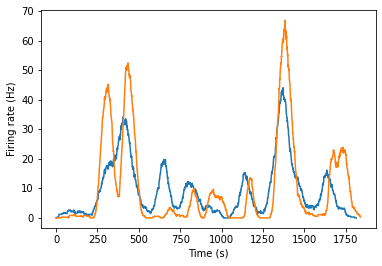

In [6]:
smooth = lambda x, wdw : np.convolve(x, np.ones(wdw)/wdw)
wdw = 40

psth = np.mean(spikes_glm, axis=2)
cell = 0
plt.plot(smooth(psth[cell,nt_integ_int:], wdw)*1000/1.667)
plt.plot(smooth(np.mean(spikes_test[cell,nt_integ_stim:,:], 1)*1000/1.667, wdw))
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.show()

In [7]:
### 2-steps
# Load interactions
path_filters = './model_filters/Int/'
with open(path_filters+'filters.pkl', 'rb') as f:
    (bias_list, stimulus_fields, coupl_filters, self_filters, tau_r_list) = pkl.load(f)

# Load LN model
path_filters = './model_filters/LN/'
with open(path_filters+'filters.pkl', 'rb') as f:
    (stim_filters, bias_list) = pkl.load(f)

In [8]:
n_rep_sim = 50

# Some parameters
nt_integ_stim = stim_filters[0].shape[1]
nt_integ_int = np.max([coupl_filters[0].shape[1],self_filters[0].shape[1]])
nt_sim = nt_test - nt_integ_stim - nt_integ_int

# Stimulus effect
stim = stimulus_test[np.newaxis,:,:, np.newaxis]-0.5
h_stim = np.zeros((n_cells, nt_sim+nt_integ_int))
for cell in range(n_cells):
    h_temp = tf.nn.conv2d(stim, stim_filters[cell], strides=1, padding='VALID')
    h_stim[cell,:] = h_temp.numpy().squeeze()[:-1]+bias_list[cell]

# Simulation
spikes_sim =  np.zeros((n_cells, nt_sim+nt_integ_int, n_rep_sim))
for rep in range(n_rep_sim):
    if (rep+1)%10==0: print(f'{rep+1} repetitions done')
    for t in range(nt_sim):
        h_past = h_stim[:,t:t+nt_integ_int]
        spikes_past = spikes_sim[:,t:t+nt_integ_int, rep]
        h_int = interaction_potential_2steps(h_past, spikes_past, coupl_filters, self_filters, tau_r_list)
        
        # predicted firing rate
        lbdt = np.exp(h_int + h_stim[:,t])
        
        # hard refractory period period
        for cell in range(n_cells):
            if np.sum(spikes_sim[cell,nt_integ_int+t-tau_r_list[cell]:nt_integ_int+t, rep])>0:
                lbdt[cell] = 0
        
        spikes_t = np.random.rand(n_cells)<lbdt
        spikes_sim[:,nt_integ_int+t, rep] = spikes_t.astype('int')

spikes_2steps = spikes_sim[:,nt_integ_int:,:]

10 repetitions done
20 repetitions done
30 repetitions done
40 repetitions done
50 repetitions done


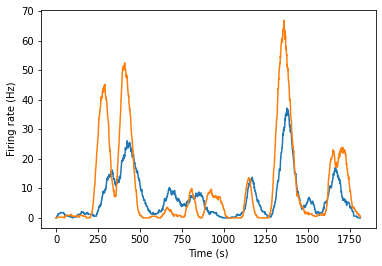

In [9]:
smooth = lambda x, wdw : np.convolve(x, np.ones(wdw)/wdw)
wdw = 40

cell = 0

plt.plot(smooth(np.mean(spikes_2steps[cell,:,:], 1), wdw)*1000/1.667)
plt.plot(smooth(np.mean(spikes_test[cell,nt_integ_stim+nt_integ_int:,:], 1), wdw)*1000/1.667)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.show()

In [10]:
### Compute noise correlations
bin_size = 20 # bin_size for the computation of noise correlations
max_spikes = np.mean(np.sum(spikes_test, axis=1)) + 3*np.std(np.sum(spikes_test, axis=1)) # maximum number of spikes for each cell, in each trial (helps to discard trials with runaway excitations)
corr_noise_data, corr_stim_data = compute_correlations(spikes_test[:,nt_integ_stim+nt_integ_int:,:], bin_size, max_spikes)
corr_noise_2steps, corr_stim_2steps = compute_correlations(spikes_2steps, bin_size, max_spikes)
corr_noise_glm, corr_stim_glm = compute_correlations(spikes_glm, bin_size, max_spikes)

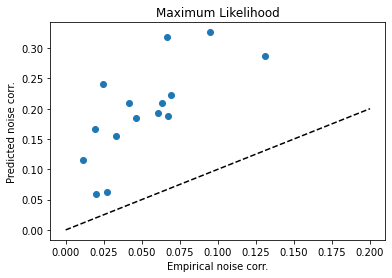

In [11]:
plt.scatter(corr_noise_data, corr_noise_glm)
plt.plot([0, 0.2], [0, 0.2], '--k')
plt.xlabel('Empirical noise corr.')
plt.ylabel('Predicted noise corr.')
plt.title('Maximum Likelihood')
plt.show()

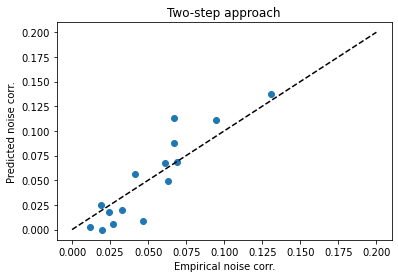

In [12]:
plt.scatter(corr_noise_data, corr_noise_2steps)
plt.plot([0, 0.2], [0, 0.2], '--k')
plt.xlabel('Empirical noise corr.')
plt.ylabel('Predicted noise corr.')
plt.title('Two-step approach')
plt.show()

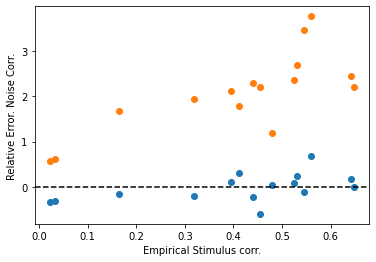

In [13]:
cutoff_noise_corr = np.max(np.stack((corr_noise_data, np.ones(int(n_cells*(n_cells-1)/2))*2*np.std(corr_noise_data)), axis=1), axis=1)

plt.scatter(corr_stim_data, (np.array(corr_noise_2steps) - np.array(corr_noise_data))/cutoff_noise_corr)
plt.scatter(corr_stim_data, (np.array(corr_noise_glm) - np.array(corr_noise_data))/cutoff_noise_corr)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Empirical Stimulus corr.')
plt.ylabel('Relative Error. Noise Corr.')
plt.show()